# StackOverflow Modeling

This workbook demonstrates machine learning models for the project.  
For data pre-processing and exploritory analysis, please refer to   
https://github.com/yuqinouou/Springboard/blob/master/Capstone_Project/notebook/StackOverflow_EDA_Questions_Quality_Final.ipynb  



In [97]:
# load packages
import re
import string
import numpy as np
import pandas as pd
import itertools
import time

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from collections import Counter
from itertools import chain

from scipy.spatial.distance import cosine
from scipy.stats import ttest_ind

from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.proportion import proportions_ztest

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, MaxAbsScaler, QuantileTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, ElasticNetCV, SGDClassifier, RidgeCV, LassoCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import roc_auc_score, f1_score, log_loss, accuracy_score, confusion_matrix
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error, r2_score

from nltk.corpus import stopwords

In [2]:
%%time
# load dataset
file_path = "/Volumes/DockerDrive/"
df = pd.read_csv(file_path+"final_df.csv", index_col = "CreationDate", parse_dates=True)
df = df.drop('Unnamed: 0', axis=1)
df['TimeToFirstAnswer'] = pd.to_timedelta(df['TimeToFirstAnswer'])
df['TimeToFirstAcceptedAnswer'] = pd.to_timedelta(df['TimeToFirstAcceptedAnswer'])

CPU times: user 46.5 s, sys: 1.82 s, total: 48.3 s
Wall time: 46.7 s


## Model 1 - Feature Clustering

Here I try to run a clustering model to cateogrize question posts with features we have.

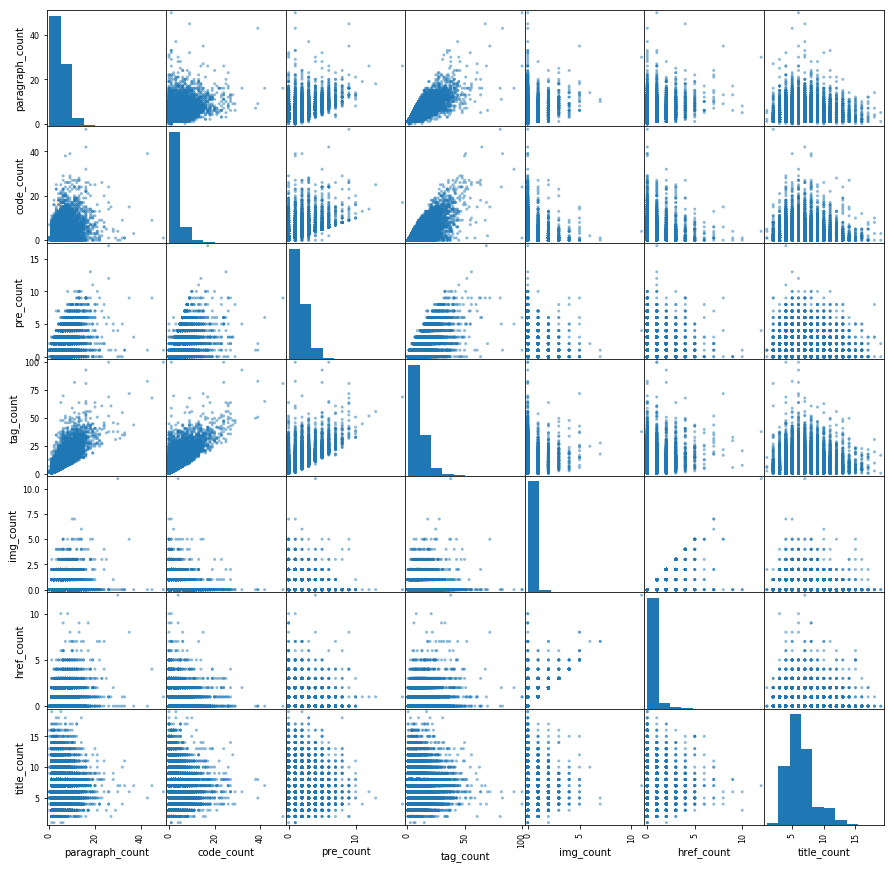

In [3]:
text_features = ['paragraph_count', 'code_count', 'pre_count', 'tag_count',
                 'img_count', 'href_count', 'title_count', 'is_question', 'is_thankful']
pd.plotting.scatter_matrix(df[text_features[0:7]].sample(frac=0.01)[
    ['paragraph_count', 'code_count', 'pre_count', 'tag_count', 
     'img_count', 'href_count', 'title_count']
], figsize = (15, 15))
plt.show()

In [4]:
scaler = StandardScaler()
pca = PCA()
#pipeline = make_pipeline(scaler, model)
text_features = ['paragraph_count', 'code_count', 'pre_count', 
                 'img_count', 'href_count', 'title_count', 'is_question', 'is_thankful']

In [5]:
df_transform = scaler.fit_transform(df[text_features])
pca.fit(df_transform)

/Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [6]:
pca.explained_variance_

array([2.08535806, 1.65745425, 1.26024877, 1.02894098, 0.7253371 ,
       0.4886375 , 0.43044201, 0.32358477])

In [7]:
df_transform = pca.transform(df_transform)

15692654.244360365
13617440.866535313
11516748.313590998
10249510.262117857
9631920.805553997
9082594.182015145
8603212.652835278
8177413.698145411
7771019.962256402
CPU times: user 32min 59s, sys: 4min 20s, total: 37min 19s
Wall time: 14min 4s


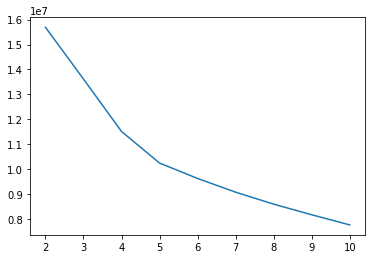

In [29]:
%%time
model_lst = []
inertia_lst = []
for i in range(2, 11):
    model = KMeans(n_clusters=i)
    model.fit(df_transform)
    print(model.inertia_)
    model_lst.append(model)
    inertia_lst.append(model.inertia_)
    
plt.plot(range(2, 11), inertia_lst)

In [8]:
#cluster_model = model_lst[3]
cluster_model = KMeans(n_clusters=5)
cluster_model.fit(df_transform)
print(cluster_model.inertia_)

10249502.927345136


In [9]:
df['label'] = cluster_model.predict(df_transform)
df_summ = df[['label'] + text_features].groupby('label').mean()

In [15]:
df_summ.round(2).to_csv(file_path+'/plt/cov_table.csv')
df_summ.round(2)

,paragraph_count,code_count,pre_count,img_count,href_count,title_count,is_question,is_thankful
label,,,,,,,,
0,7.32,2.34,1.17,1.84,2.64,6.54,0.32,0.33
1,3.50,1.83,1.09,0.06,0.21,5.75,0.00,0.00
2,4.29,1.64,1.09,0.07,0.22,6.33,0.32,1.00
3,8.41,7.32,3.70,0.06,0.32,6.45,0.25,0.30
4,3.29,1.83,0.98,0.06,0.21,7.18,1.00,0.00


In [11]:
df['label'].value_counts()

1    847731
2    578392
4    498302
3    299060
0    101812
Name: label, dtype: int64

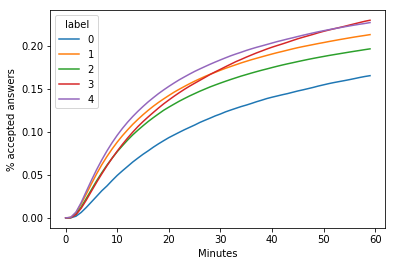

In [12]:
plot_data = pd.concat([df.groupby('label')['TimeToFirstAcceptedAnswer'].apply(
    lambda x: pd.Series(np.mean((x.notna()) & (x <= timedelta(minutes = i))), [i])) for i in range(0, 60)])
plot_data = pd.DataFrame(plot_data).reset_index()
plot_data.columns = ['label', 'Minutes', 'Cumulative_Percentage']
plot_data.pivot(index='Minutes', columns='label', values='Cumulative_Percentage').plot()
plt.ylabel('% accepted answers')
plt.savefig(file_path+'/plt/cluster1.png')
plt.show()

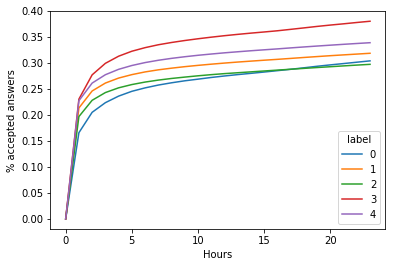

In [13]:
plot_data = pd.concat([df.groupby('label')['TimeToFirstAcceptedAnswer'].apply(
    lambda x: pd.Series(np.mean((x.notna()) & (x <= timedelta(hours = i))), [i])) for i in range(0, 24)])
plot_data = pd.DataFrame(plot_data).reset_index()
plot_data.columns = ['label', 'Hours', 'Cumulative_Percentage']
plot_data.pivot(index='Hours', columns='label', values='Cumulative_Percentage').plot()
plt.ylabel('% accepted answers')
plt.savefig(file_path+'/plt/cluster2.png')
plt.show()

I chose five cluster since the magnitute for inertia declining slows down past 5 clusters. By checking mean values for each feature, we can get an idea of different styles of question posting:  
    0. wordy questions with a lot paragraphs and code chunks.  
    1. questions with narritive title and no thankful words.  
    2. questions with question title and no thankful words.  
    3. wordy questions with a lot paragraphs, less code chunks but more images and external links.  
    4. questions with thankful workds.  
    
Looking at time to first accepted answer, Level 0 category has different trend comparing with others. It takes a while to get a quality answer, but after 45 minute mark, it will be the most likely to get answered.  

Other categories has approximately the same shape of the curve, but different proportion of getting an answer, with Level 2 questions at the top, followed by Level 1 and Level 4. Level 3 is the least likely category.  

Comparing 1 to 2, it is more appreciated if the title is a question not a statement. Comparing 1,2 with 4, we got the feeling that it's actually unnecessary to be 'polite'. To me this is counter-intuitive, no one hates good manners.  

But I think this implies we missed some important features that confounded the result. For example, less-experienced programmers might be less confident in their narritive to the question, and being extremely polite, while it can also be associated with question quality issues such as duplications or unclear question description. Finally, when we look at Level 3, if a lot images and hyperlinks are added to a post, it actually does damage and less likely to get an answer. However, if we extend the time window to one day, Level 3 question will get more answers. It could be those questions are usually full of information, and takes longer to get an good answer, but there is nothing wrong with the question itself.


## Model 2 - Survival Analysis

The secondary model is to run a Cox-Regression to detect the magnitude for features to predict time-to-first-answer. But the caveat is also obvious - proportional hazard is a very strong assumption. Nevertheless, we try to run this model and see what the model fit looks like.  

In [14]:
import glmnet_python
from glmnet import glmnet
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from glmnet import glmnet; from glmnetPlot import glmnetPlot
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

In [182]:
# get txt features
df_par = pd.get_dummies(pd.cut(df['paragraph_count'], [-1, 0, 5, 999], 
                               labels=['par0','par1_5','par6_']), drop_first=True).reset_index(drop=True).astype(float)
df_code = pd.get_dummies(pd.cut(df['code_count'], [-1, 0, 2, 999], 
                                labels=['code0','code1_2','code3_']), drop_first=True).reset_index(drop=True).astype(float)
df_pre = pd.get_dummies(pd.cut(df['pre_count'], [-1, 0, 2, 999], 
                               labels=['pre0','pre1_2','pre3_']), drop_first=True).reset_index(drop=True).astype(float)
df_tag = pd.get_dummies(pd.cut(df['tag_count'], [-1, 2, 10, 999], 
                               labels=['tag0_2','tag3_10','tag11_']), drop_first=True).reset_index(drop=True).astype(float)
df_img = pd.get_dummies(pd.cut(df['img_count'], [-1, 0, 1, 999], 
                               labels=['img0','img1','img2_']), drop_first=True).reset_index(drop=True).astype(float)
df_href = pd.get_dummies(pd.cut(df['href_count'], [-1, 0, 1, 999], 
                                labels=['href0','href1','href2_']), drop_first=True).reset_index(drop=True).astype(float)
df_title = pd.get_dummies(pd.cut(df['title_count'], [0, 3, 8, 999], 
                                 labels=['title1_3','title4_8','title9_']), drop_first=True).reset_index(drop=True).astype(float)

In [183]:
df_is = df[['is_question','is_thankful']].astype(float).reset_index(drop=True)

In [6]:
# get time features
df_wd = pd.DataFrame(df.index.weekday.isin([0,1,2,3,4]).astype(float))
df_wd.columns=['isweekday']

In [7]:
# get tag features top 30 tags
df.Tag_Doc[df.Tag_Doc.isna()] = ['NA']*5
cv = CountVectorizer(min_df=1000, max_features=30, token_pattern='\S+')
counts = cv.fit_transform(df.Tag_Doc)
df_posttag = pd.DataFrame(pd.SparseDataFrame(counts))
words = np.array(cv.get_feature_names()) 
df_posttag.columns = words
df_posttag = df_posttag.fillna(0)

/Users/ouou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
# get outcome measure, truncate to first hour.
t = df['TimeToFirstAcceptedAnswer'].copy()
t[t.isna()] = timedelta(days=999)
ind = (t <= timedelta(hours=24))
stime = np.minimum((t/timedelta(minutes=1)).astype(int), timedelta(hours=24)/timedelta(minutes=1))

In [8]:
df_y = pd.DataFrame({'time':stime, 'ind':ind})
df_y.head()

,time,ind
CreationDate,,
2017-01-01 00:00:04.523,1440.0,False
2017-01-01 00:00:39.710,70.0,True
2017-01-01 00:02:06.737,1440.0,False
2017-01-01 00:02:29.813,11.0,True
2017-01-01 00:03:28.577,1440.0,False


In [9]:
# create input matrix
x = pd.concat([df_par, df_code, df_pre, df_tag, df_img, df_href, df_title, df_is, df_wd, df_posttag], axis=1, ignore_index=True)
col_lst = [d.columns for d in [df_par, df_code, df_pre, df_tag, df_img, df_href, df_title, df_is, df_wd, df_posttag]]
col_name = list(itertools.chain.from_iterable(col_lst))
x.columns = col_name
x['intercept'] = 1
y = df_y

In [21]:
x = np.array(x.astype(np.float64))
y = np.array(y.astype(np.float64))

In [15]:
fit = glmnet(x = x[0:1000].copy(), y = y[0:1000].copy(), family = 'cox')

OSError: dlopen(/Users/ouou/anaconda3/lib/python3.7/site-packages/glmnet_python/GLMnet.so, 6): Library not loaded: /usr/local/gfortran/lib/libquadmath.0.dylib
  Referenced from: /Users/ouou/anaconda3/lib/python3.7/site-packages/glmnet_python/GLMnet.so
  Reason: image not found

## Model 3 - Classification Model

We tried to fit a classification model to predict if a question will get answered within a day.

In [3]:
# get outcome class, <=1day, >1day
t = df['TimeToFirstAcceptedAnswer'].copy()
t[t.isna()] = timedelta(days=999)
t=t/timedelta(minutes=1)
#y = pd.cut(t, [-1, 60, 60*24, np.inf], labels=['Less than 1h', 'Less than 1d', 'Need more time'])
y = np.array(t<=60*24)

In [4]:
np.mean(y)

0.32683996925984077

,android,angular,angularjs,arrays,asp.net,c,c#,c++,css,django,...,python,python-3.x,r,reactjs,ruby-on-rails,spring,sql,sql-server,swift,wordpress
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
#df = df.reset_index()
text_features = ['paragraph_count', 'code_count', 'pre_count', 'tag_count',
                 'img_count', 'href_count', 'title_count', 'is_question', 'is_thankful']

logdf = pd.DataFrame({'paragraph_count':np.log(1+df['paragraph_count']),
                      'code_count':np.log(1+df['code_count']),
                      'pre_count':np.log(1+df['pre_count']),
                      'tag_count':np.log(1+df['tag_count']),
                      'img_count':np.log(1+df['img_count']),
                      'href_count':np.log(1+df['href_count']),
                      'title_count':df['title_count'],
                      'is_question':df['is_question'],
                      'is_thankful':df['is_thankful'],
                     }).reset_index(drop=True)

x = pd.concat([logdf, df_wd, df_posttag], axis=1, ignore_index=True)
col_lst = [d.columns for d in [logdf, df_wd, df_posttag]]
col_name = list(itertools.chain.from_iterable(col_lst))
x.columns = col_name
# x['intercept'] = 1
scaler = StandardScaler()
pca = PCA()
x_scaled = scaler.fit_transform(x)
x_transform = pca.fit_transform(x_scaled)

/Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [98]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    #"Nearest Neighbors": KNeighborsClassifier(),
    #"Linear SVM": SVC(),
    #"Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=20),
    "Decision Tree": tree.DecisionTreeClassifier(max_depth = 6),
    #"Random Forest": RandomForestClassifier(n_estimators = 500, max_depth = 10, n_jobs=-1),
    #"Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": BernoulliNB(),
    #"AdaBoost": AdaBoostClassifier(),
    #"QDA": QuadraticDiscriminantAnalysis(),
    #"Gaussian Process": GaussianProcessClassifier()
}

def batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 5, verbose = True):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
    is because it is very easy to save the whole dictionary with the pickle module.
    """
    
    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()
        
        t_diff = t_end - t_start
        
        #train_score = classifier.score(X_train, Y_train)
        #test_score = classifier.score(X_test, Y_test)
        
        #train_score = roc_auc_score(Y_train, classifier.predict_proba(X_train)[:,1])
        #test_score = roc_auc_score(Y_test, classifier.predict_proba(X_test)[:,1])
        
        train_score = log_loss(Y_train, classifier.predict_proba(X_train)[:,1])
        test_score = log_loss(Y_test, classifier.predict_proba(X_test)[:,1])
        
        #train_score = f1_score(Y_train, classifier.predict(X_train))
        #test_score = f1_score(Y_test, classifier.predict(X_test))
        
        dict_models[classifier_name] = {'model': classifier, 'train_score': train_score, 'test_score': test_score, 'train_time': t_diff}
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))
    return dict_models

def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),4)), columns = ['classifier', 'train_score', 'test_score', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]
    
    display(df_.sort_values(by=sort_by, ascending=False))

In [99]:
dict_models = batch_classify(x_train, y_train, x_test, y_test, no_classifiers = 8)
display_dict_models(dict_models)
import pickle
filename = file_path+'/model/models.sav'
pickle.dump(dict_models, open(filename, 'wb'))

/Users/ouou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ouou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


trained Logistic Regression in 17.75 s


/Users/ouou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/ouou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


trained Decision Tree in 78.45 s


/Users/ouou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/ouou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


trained Random Forest in 12957.88 s


/Users/ouou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/ouou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


trained Naive Bayes in 3.24 s


,classifier,train_score,test_score,train_time
3,Naive Bayes,0.642418,0.642873,3.235518
1,Decision Tree,0.613915,0.614339,78.447367
0,Logistic Regression,0.611342,0.611629,17.745947
2,Random Forest,0.604834,0.608507,12957.879036


In [ ]:
#import pickle
#filename = 'finalized_model.sav'
#pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

In [94]:
time.clock()

/Users/ouou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


1395.198258

In [93]:
time.perf_counter()

13940.869969164

In [103]:
importances = dict_models['Random Forest']['model'].feature_importances_

In [104]:
importances

array([0.13858838, 0.06214307, 0.08444772, 0.08133701, 0.01697625,
       0.03858133, 0.00952308, 0.00860994, 0.00532293, 0.01732936,
       0.04035164, 0.01956156, 0.009213  , 0.01327995, 0.01343623,
       0.01159076, 0.01162461, 0.02702821, 0.01019345, 0.01897229,
       0.01002161, 0.02915934, 0.0146165 , 0.01237586, 0.0113457 ,
       0.02268934, 0.00901503, 0.02977803, 0.01329073, 0.01531768,
       0.00828755, 0.044897  , 0.02183755, 0.01846622, 0.01757755,
       0.01612428, 0.03028996, 0.00795122, 0.01801098, 0.01083711])

### Logistic Regression

SGD with log-loss gives us a logistic regression estimator. We can try to evaluate how good our features are in predicting answer response.

In [203]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 123, stratify = y)
param_grid = {'l1_ratio': [0, 0.05, 0.1, 0.5, 0.7, 1],
              'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1] }
enet = SGDClassifier(loss = 'log', penalty = 'elasticnet', class_weight='balanced')
cv = GridSearchCV(enet, param_grid=param_grid, scoring='roc_auc', n_jobs=6, cv=5, verbose=1)
cv = cv.fit(x_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 180 out of 180 | elapsed: 36.1min finished
/Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [204]:
pd.DataFrame(cv.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')

/Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/ouou/anaconda3/lib/python3.

,params,mean_test_score,rank_test_score
13,"{'alpha': 0.001, 'l1_ratio': 0.05}",0.622974,1
14,"{'alpha': 0.001, 'l1_ratio': 0.1}",0.622878,2
12,"{'alpha': 0.001, 'l1_ratio': 0}",0.622860,3
9,"{'alpha': 0.0001, 'l1_ratio': 0.5}",0.622281,4
8,"{'alpha': 0.0001, 'l1_ratio': 0.1}",0.622250,5
10,"{'alpha': 0.0001, 'l1_ratio': 0.7}",0.622210,6
11,"{'alpha': 0.0001, 'l1_ratio': 1}",0.622171,7
7,"{'alpha': 0.0001, 'l1_ratio': 0.05}",0.622022,8
6,"{'alpha': 0.0001, 'l1_ratio': 0}",0.621923,9
15,"{'alpha': 0.001, 'l1_ratio': 0.5}",0.620233,10


with l1_ratio = 0.05 and alpha = 1e-3, our best model yields a roc_auc of 0.623. This is considered a mediocre model with not much prediction power than random guess. We can check other score measures on both training and testing sets.

In [208]:
print(log_loss(y_train, cv.predict_proba(x_train)[:,1]))
print(log_loss(y_test, cv.predict_proba(x_test)[:,1]))
print(roc_auc_score(y_train, cv.predict_proba(x_train)[:,1]))
print(roc_auc_score(y_test, cv.predict_proba(x_test)[:,1]))
print(f1_score(y_train, cv.predict(x_train)))
print(f1_score(y_test, cv.predict(x_test)))
print(accuracy_score(y_train, cv.predict(x_train)))
print(accuracy_score(y_test, cv.predict(x_test)))           
print(confusion_matrix(y_test, cv.predict(x_test)))  

0.673319000377713
0.6736034012042373
0.6229408794583284
0.6218927573484222
0.4910300145523306
0.4902017395694125
0.5779879302601758
0.5772918189767628
[[260942 208648]
 [ 86229 141771]]


Confusion matrix implies that our model has too many false positives. The coefficient table below can give us an idea of the contribution of each feature to the model.

In [206]:
coef_df = pd.DataFrame(cv.best_estimator_.coef_)
coef_df.columns = x.columns
coef_df = coef_df.transpose()
coef_df.columns = ['Coefficient']

In [207]:
coef_df

,Coefficient
paragraph_count,-0.243712
code_count,0.317581
pre_count,0.183124
tag_count,0.120122
img_count,0.170960
href_count,-0.095041
title_count,-0.039589
is_question,0.170516
is_thankful,-0.072432
isweekday,-0.021212


For the derived features from text, we can see it's good to have more code chunks, pre-formatting and imagies, and it's not suggeted to have too many paragraphs or too many external links. It is good to state you question as an actual question, not in a statement. The length of title and when it got posted doesn't matter that much.  
Next, we can demonstrate some sample questions with high and low prediction probabilities.

In [261]:
prob_test = cv.predict_proba(x_test)
prob_test_array = np.copy(prob_test[:,1])

#inds = x_test.index[prob_test[:,1].argsort()]

#prob_test[:,1].argmax(axis=0)
#np.max(prob_test)
#ind = x_test.index[prob_test[:,1].argmax(axis=0)]

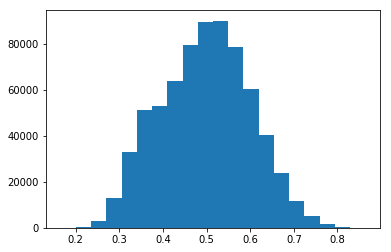

In [267]:
plt.hist(prob_test_array, bins=20)
plt.show()

In [269]:
prob_test_array.sort()
print(prob_test_array[-11:-1])
print(prob_test_array[0:10])

[0.84799946 0.84816112 0.8490574  0.84944708 0.84979645 0.8509825
 0.8518574  0.85554134 0.85621462 0.85657387]
[0.16607608 0.16643854 0.16825288 0.18086134 0.18201649 0.18472717
 0.19063072 0.1917456  0.19252381 0.19398724]


In [270]:
inds = x_test.index[prob_test[:,1].argsort()]

In [271]:
df.iloc[inds[-11:-1]]

,level_0,index,CreationDate,Id,paragraph_count,code_count,pre_count,tag_count,img_count,href_count,title_count,is_question,is_thankful,Tag_Doc,AcceptedAnswerId,TimeToFirstAnswer,TimeToFirstAcceptedAnswer,label
2039445,2039445,2039445,2017-10-24 15:45:03.367,46914803,14,34,17,71,0,0,8,True,False,php arrays regex preg-replace preg-replace-cal...,0,NaT,NaT,3
170990,170990,170990,2017-01-26 19:23:36.637,41881321,8,13,7,32,0,1,5,True,False,javascript arrays json object,41881385,0 days 00:01:49.236000,0 days 00:03:18.126000,3
1127212,1127212,1127212,2017-06-09 07:37:13.080,44451988,7,31,6,44,0,0,7,False,False,javascript arrays angular typescript observable,44452453,0 days 00:24:24.130000,0 days 00:24:24.130000,3
741868,741868,741868,2017-04-15 02:38:09.860,43421603,8,14,5,27,0,0,7,False,True,javascript jquery python html css,0,NaT,NaT,3
1572287,1572287,1572287,2017-08-12 19:34:39.657,45654196,9,25,7,41,0,0,6,False,False,python c++ c ctypes,45687146,2 days 10:16:46.590000,2 days 10:16:46.590000,3
1317469,1317469,1317469,2017-07-06 23:42:18.593,44960436,3,3,1,7,0,0,4,True,False,javascript jquery html css arrays,44960705,0 days 00:40:36.430000,0 days 00:40:36.430000,4
820760,820760,820760,2017-04-26 12:08:21.263,43633774,9,22,6,37,0,0,8,True,False,python arrays performance numpy vectorization,43634323,0 days 00:24:35.764000,0 days 00:24:35.764000,3
999353,999353,999353,2017-05-22 10:00:38.943,44110025,7,24,6,41,0,0,4,False,False,c arrays pointers scope lifetime,44110097,0 days 00:03:11.014000,0 days 00:03:11.014000,3
201569,201569,201569,2017-01-31 18:21:07.327,41964759,7,7,5,21,0,0,4,True,False,php mysql sql arrays,0,0 days 00:07:43.143000,NaT,3
165516,165516,165516,2017-01-26 03:54:03.390,41866637,5,18,2,40,1,2,9,True,False,javascript jquery arrays json,0,0 days 00:19:43.533000,NaT,3


In [273]:
df.iloc[inds[0:10]]

,level_0,index,CreationDate,Id,paragraph_count,code_count,pre_count,tag_count,img_count,href_count,title_count,is_question,is_thankful,Tag_Doc,AcceptedAnswerId,TimeToFirstAnswer,TimeToFirstAcceptedAnswer,label
261375,261375,261375,2017-02-09 00:45:34.100,42126305,22,0,0,25,0,1,16,False,True,wordpress loops custom-taxonomy,42127090,0 days 01:30:03.817000,01:30:03.817000,3
1228569,1228569,1228569,2017-06-23 13:07:55.187,44722255,5,0,0,5,0,5,19,False,True,ios objective-c ios10 xib,0,NaT,NaT,0
1563293,1563293,1563293,2017-08-11 07:09:28.490,45629029,8,0,0,8,0,1,14,False,True,android ios cordova ionic-framework facebook-j...,0,NaT,NaT,2
305770,305770,305770,2017-02-15 10:37:48.430,42246961,2,0,0,2,0,0,14,False,True,android ios angularjs ionic-framework hybrid-m...,0,NaT,NaT,2
1340301,1340301,1340301,2017-07-10 22:35:17.713,45022677,9,0,0,9,0,3,18,False,True,django django-cms,0,NaT,NaT,2
1639369,1639369,1639369,2017-08-23 10:45:24.223,45837549,2,0,0,2,0,0,10,False,True,android ios asp.net asp.net-core push-notifica...,0,NaT,NaT,2
372103,372103,372103,2017-02-23 23:35:28.863,42428188,7,0,0,7,0,1,14,False,True,asp.net .net visual-studio visual-studio-2015 ...,0,175 days 08:15:24.437000,NaT,2
1306295,1306295,1306295,2017-07-05 15:42:08.523,44930698,3,0,0,3,0,0,16,False,False,android ios linux go web,0,0 days 00:57:38.460000,NaT,4
1510777,1510777,1510777,2017-08-03 13:36:05.560,45485867,16,1,0,19,0,1,20,False,True,node.js sockets video webrtc kurento,0,NaT,NaT,2
458668,458668,458668,2017-03-08 03:01:30.160,42662173,10,0,0,25,0,5,15,False,True,ios itunesconnect,0,NaT,NaT,0


The model seems doing okay when predicting negatives. But when predicting positives it generates a lot errors.

## Quantile Regression  

We can look at the problem as a regression question as well. Since a large proportion of our data does not get answered, I only looked at those got an accepted answer. Time scale was transformed in minutes.  
The plot below demonstrated the response histogram in log(10) scale. We can see after transforming the data with log10, it still seems a little skewed to the right. We applied quantile transformation and evaluate the model with MAE.

In [10]:
t = np.copy(df['TimeToFirstAcceptedAnswer'].dropna()/timedelta(minutes=1))

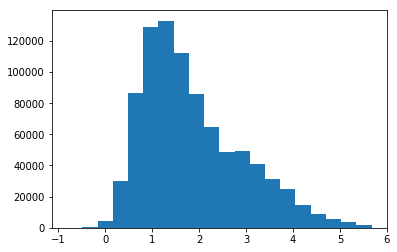

In [11]:
plt.hist(np.log10(t), bins=20)
plt.show()

In [21]:
# subset to questions got answers
x_witht = x[df['TimeToFirstAcceptedAnswer'].notna().reset_index(drop=True)]
y_witht = df['TimeToFirstAcceptedAnswer'].dropna().reset_index(drop=True)/timedelta(minutes=1)

In [24]:
x.columns

Index(['paragraph_count', 'code_count', 'pre_count', 'tag_count', 'img_count',
       'href_count', 'title_count', 'is_question', 'is_thankful', 'isweekday',
       'android', 'angular', 'angularjs', 'arrays', 'asp.net', 'c', 'c#',
       'c++', 'css', 'django', 'excel', 'html', 'ios', 'java', 'javascript',
       'jquery', 'json', 'mysql', 'node.js', 'php', 'python', 'python-3.x',
       'r', 'reactjs', 'ruby-on-rails', 'spring', 'sql', 'sql-server', 'swift',
       'wordpress'],
      dtype='object')

In [33]:
%%time
interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
x_int = interaction.fit_transform(x_witht[['paragraph_count', 'code_count', 'pre_count', 'tag_count', 'img_count',
       'href_count', 'title_count', 'is_question', 'is_thankful', 'isweekday']])

CPU times: user 16.8 s, sys: 3.47 s, total: 20.3 s
Wall time: 7.8 s


In [63]:
x_witht = x_witht.reset_index(drop=True)
x_int = pd.DataFrame(x_int)
x_final = pd.concat([x_int, x_witht.iloc[:,10:30]], axis=1)

In [ ]:
x_train, x_test, y_train, y_test, ind_train, ind_test = train_test_split(
    x_final, y_witht, range(len(y_witht)), test_size = 0.30, random_state = 123)

CPU times: user 31 s, sys: 5.4 s, total: 36.4 s
Wall time: 18.5 s


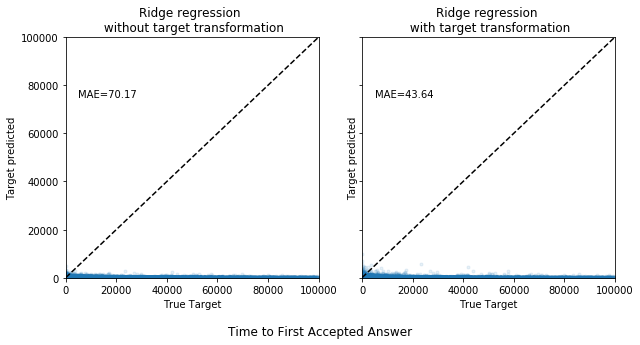

In [328]:
%%time
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
regr_trans = TransformedTargetRegressor(regressor=RidgeCV(),
                                        func=np.log,
                                        inverse_func=np.exp)

regr_trans.fit(x_train, y_train)
y_pred = regr_trans.predict(x_test)

ax0.scatter(y_test, y_pred, marker='.', alpha=0.1)
ax0.plot([0, 100000], [0, 100000], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(5000, 75000, r'MAE=%.2f' % (
    median_absolute_error(y_test, y_pred)))
ax0.set_xlim([0, 100000])
ax0.set_ylim([0, 100000])

interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(output_distribution='normal'))

x_train_int = interaction.fit_transform(x_train)
x_test_int = interaction.fit_transform(x_test)
regr_trans.fit(x_train_int, y_train)
y_pred = regr_trans.predict(x_test_int)

ax1.scatter(y_test, y_pred, marker='.', alpha=0.1)
ax1.plot([0, 100000], [0, 100000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(5000, 75000, r'MAE=%.2f' % (
    median_absolute_error(y_test, y_pred)))
ax1.set_xlim([0, 100000])
ax1.set_ylim([0, 100000])

f.suptitle("Time to First Accepted Answer", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

In [337]:
regr_trans.regressor_.coef_

array([ 0.27683776, -0.06694613, -0.134451  ,  0.04361215, -0.1794784 ,
        0.31271529,  0.02979833, -0.07886596, -0.00210781, -0.06685557,
       -0.0990168 , -0.20676914, -0.11975567, -0.40280681,  0.07342852,
       -0.45224641, -0.23231849, -0.35472926, -0.37369497,  0.00884287,
       -0.30660242, -0.25016998,  0.03887119, -0.21996925, -0.30026885,
       -0.22327459, -0.0918795 , -0.31986261,  0.02238599, -0.29912639,
       -0.40364491, -0.15987284, -0.29601948, -0.15225943, -0.14587392,
        0.22566612, -0.51131217, -0.2808226 , -0.23116512,  0.09926763])

In [108]:
%%time
regr_trans = TransformedTargetRegressor(
    regressor=LassoCV(n_alphas=100,
                    #alphas=(0.001, 0.01, 0.1, 1.0, 10.0), 
                      cv = 5, 
                      n_jobs=6,
                      verbose=True
                      #scoring="neg_mean_absolute_error"
                     ),
    transformer=QuantileTransformer(output_distribution='normal'))

regr_trans.fit(x_train, y_train)
y_pred = regr_trans.predict(x_test)

mae_train = median_absolute_error(y_train, regr_trans.predict(x_train))
mae_test = median_absolute_error(y_test, y_pred)


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
......................................................................................................................................................................./Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
............/Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
.........../Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

./Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

CPU times: user 9min 52s, sys: 1min 13s, total: 11min 5s
Wall time: 2min 53s


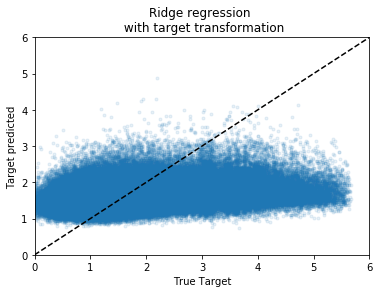

In [109]:
plt.plot([0, 6], [0, 6], '--k')
plt.scatter(np.log10(y_test), np.log10(y_pred), marker='.', alpha=0.1)
plt.ylabel('Target predicted')
plt.xlabel('True Target')
plt.title('Ridge regression \n with target transformation')
plt.xlim([0, 6])
plt.ylim([0, 6])
plt.show()

In [110]:
print(mae_train, mae_test)

41.40788929802528 41.31505451475702


In [112]:
regr_trans.regressor_.alpha_

0.002018816698918978

(array([8.0000e+00, 9.9000e+01, 1.9320e+03, 1.1267e+04, 2.8029e+04,
        3.9090e+04, 3.9213e+04, 3.2061e+04, 2.4824e+04, 1.8789e+04,
        1.4104e+04, 1.5144e+04, 1.1655e+04, 9.2940e+03, 7.3740e+03,
        4.1420e+03, 2.6600e+03, 1.7080e+03, 1.1430e+03, 5.0000e+02]),
 array([-1.7269085 , -0.98805805, -0.2492076 ,  0.48964284,  1.22849329,
         1.96734374,  2.70619418,  3.44504463,  4.18389508,  4.92274552,
         5.66159597,  6.40044642,  7.13929686,  7.87814731,  8.61699776,
         9.3558482 , 10.09469865, 10.8335491 , 11.57239954, 12.31124999,
        13.05010044]),
 <a list of 20 Patch objects>)

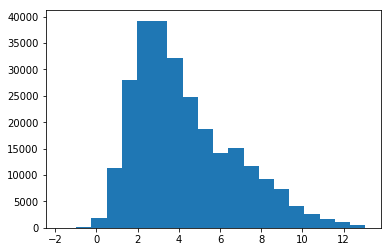

In [74]:
plt.hist(np.log(y_test), bins=20)

(array([7.5000e+01, 1.4100e+03, 7.2500e+03, 1.9697e+04, 4.3838e+04,
        6.3505e+04, 4.7685e+04, 3.4649e+04, 2.3255e+04, 1.1505e+04,
        5.5000e+03, 2.4730e+03, 1.1640e+03, 5.7500e+02, 3.0100e+02,
        1.0300e+02, 2.5000e+01, 1.4000e+01, 7.0000e+00, 5.0000e+00]),
 array([1.48027245, 1.85224609, 2.22421973, 2.59619337, 2.968167  ,
        3.34014064, 3.71211428, 4.08408792, 4.45606156, 4.8280352 ,
        5.20000883, 5.57198247, 5.94395611, 6.31592975, 6.68790339,
        7.05987703, 7.43185066, 7.8038243 , 8.17579794, 8.54777158,
        8.91974522]),
 <a list of 20 Patch objects>)

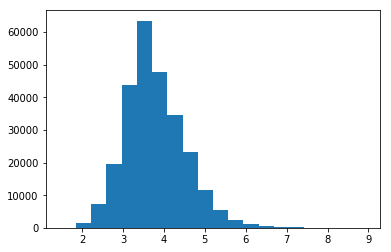

In [75]:
plt.hist(np.log(y_pred), bins=20)

In [107]:
np.max(y_pred)

73879.44801870646

DRAFE BELOW

In [189]:
# create input matrix
x_dummy = pd.concat([df_par, df_code, df_pre, df_tag, df_img, df_href, df_title, df_is, df_wd, df_posttag], axis=1, ignore_index=True)
col_lst = [d.columns for d in [df_par, df_code, df_pre, df_tag, df_img, df_href, df_title, df_is, df_wd, df_posttag]]
col_name = list(itertools.chain.from_iterable(col_lst))
x_dummy.columns = col_name

x_train, x_test, y_train, y_test = train_test_split(x_dummy, y, test_size = 0.30, random_state = 123, stratify = y)
#param_grid = {'l1_ratio': [0, 0.05, 0.1, 0.5, 1],
#              'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01] }
#enet = SGDClassifier(loss = 'log', penalty = 'elasticnet', n_jobs = -1, verbose = 1)
#cv = GridSearchCV(enet, param_grid=param_grid, scoring='neg_log_loss', n_jobs=-1, cv=5, verbose=1)
#cv = cv.fit(x_train, y_train)

In [194]:
enet = SGDClassifier(loss = 'log', penalty = 'elasticnet', n_jobs = -1, verbose = 1, alpha=1e-3, l1_ratio=0, class_weight='balanced')
enet.fit(x_train, y_train)
enet.score(x_train, y_train)


/Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


-- Epoch 1
Norm: 1.59, NNZs: 47, Bias: -0.869309, T: 1627707, Avg. loss: 0.674525
Total training time: 1.06 seconds.
-- Epoch 2
Norm: 1.62, NNZs: 47, Bias: -0.831380, T: 3255414, Avg. loss: 0.669954
Total training time: 2.20 seconds.
-- Epoch 3
Norm: 1.62, NNZs: 47, Bias: -0.837316, T: 4883121, Avg. loss: 0.669906
Total training time: 3.28 seconds.
-- Epoch 4
Norm: 1.61, NNZs: 47, Bias: -0.848003, T: 6510828, Avg. loss: 0.669872
Total training time: 4.21 seconds.
-- Epoch 5
Norm: 1.61, NNZs: 47, Bias: -0.847657, T: 8138535, Avg. loss: 0.669823
Total training time: 5.17 seconds.


0.5766154473747425

In [200]:
print(roc_auc_score(y_test, enet.predict_proba(x_test)[:,1]))

0.6216680310520973


In [196]:
print(confusion_matrix(y_test, enet.predict(x_test))) 

[[260078 209512]
 [ 86122 141878]]


In [199]:
np.sum(y_test)

228000

In [201]:
x.head()

,paragraph_count,code_count,pre_count,tag_count,img_count,href_count,title_count,is_question,is_thankful,isweekday,...,python,python-3.x,r,reactjs,ruby-on-rails,spring,sql,sql-server,swift,wordpress
0,1.386294,1.098612,1.098612,2.079442,0.0,0.000000,3,False,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.791759,1.791759,0.693147,2.484907,0.0,0.000000,6,False,False,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.397895,1.945910,1.791759,3.135494,0.0,0.000000,11,True,True,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.609438,2.079442,1.098612,2.639057,0.0,0.000000,7,True,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.791759,2.079442,1.098612,2.708050,0.0,0.693147,3,True,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
pca = PCA()
pca.fit(x_int)
pca.explained_variance_ratio_

array([1.07452148e+03, 1.75258571e+02, 1.49617855e+02, 1.30657033e+02,
       8.95104224e+01, 7.46586576e+01, 5.99559124e+01, 2.59345002e+01,
       2.52295052e+01, 7.35162158e+00, 6.10183387e+00, 4.99245318e+00,
       4.26078893e+00, 3.95874093e+00, 2.92485224e+00, 2.67408763e+00,
       2.64606326e+00, 2.17341720e+00, 2.06986214e+00, 1.91661508e+00,
       1.85512136e+00, 1.65161991e+00, 1.56645643e+00, 1.48618104e+00,
       1.33309635e+00, 1.30199412e+00, 1.25348432e+00, 1.16205399e+00,
       1.05819208e+00, 1.03271603e+00, 9.43448502e-01, 8.00286101e-01,
       6.57690458e-01, 5.27888650e-01, 5.01000265e-01, 4.52088700e-01,
       4.37693183e-01, 4.18220178e-01, 3.86958787e-01, 3.58680570e-01,
       3.45602683e-01, 2.90724599e-01, 2.89383618e-01, 2.57619046e-01,
       2.51009888e-01, 2.28235044e-01, 2.06796425e-01, 1.80256580e-01,
       1.70998941e-01, 1.62757536e-01, 1.46241518e-01, 1.23486663e-01,
       1.13066375e-01, 1.01409968e-01, 7.94325216e-02, 7.29289867e-02,
      

In [115]:
pca.explained_variance_ratio_

array([5.74728970e-01, 9.37404975e-02, 8.00260556e-02, 6.98844868e-02,
       4.78764118e-02, 3.99326530e-02, 3.20686002e-02, 1.38715781e-02,
       1.34944976e-02, 3.93215955e-03, 3.26368598e-03, 2.67031188e-03,
       2.27896685e-03, 2.11741053e-03, 1.56441481e-03, 1.43028842e-03,
       1.41529903e-03, 1.16249498e-03, 1.10710652e-03, 1.02513931e-03,
       9.92248184e-04, 8.83401426e-04, 8.37850063e-04, 7.94913192e-04,
       7.13032830e-04, 6.96397190e-04, 6.70450770e-04, 6.21547456e-04,
       5.65994870e-04, 5.52368503e-04, 5.04622007e-04, 4.28048778e-04,
       3.51778691e-04, 2.82351638e-04, 2.67969856e-04, 2.41808542e-04,
       2.34108817e-04, 2.23693296e-04, 2.06972526e-04, 1.91847365e-04,
       1.84852399e-04, 1.55499776e-04, 1.54782526e-04, 1.37792619e-04,
       1.34257581e-04, 1.22076007e-04, 1.10609139e-04, 9.64137810e-05,
       9.14621502e-05, 8.70540726e-05, 7.82201550e-05, 6.60492729e-05,
       6.04757768e-05, 5.42411181e-05, 4.24860481e-05, 3.90075044e-05,
      

In [116]:
x_int_transform = pca.transform(x_int)

1035390037.0206407
865713343.839452
792627859.3571488
741997772.5424742
698923977.8579241
660691119.3344233
632962925.0010482
608229881.3849239
584594572.7133236
CPU times: user 8min 49s, sys: 1min 9s, total: 9min 58s
Wall time: 8min 6s


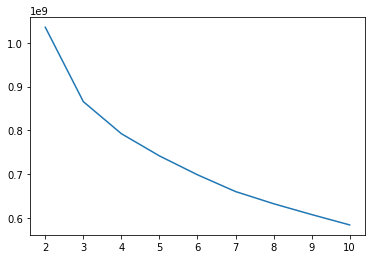

In [120]:
%%time
model_lst = []
inertia_lst = []
for i in range(2, 11):
    model = KMeans(n_clusters=i)
    model.fit(x_int_transform[:,0:20])
    print(model.inertia_)
    model_lst.append(model)
    inertia_lst.append(model.inertia_)
    
plt.plot(range(2, 11), inertia_lst)

In [122]:
model_lst[-1]

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [133]:
df_witht['label'] = model_lst[-1].predict(x_int_transform[:,0:20])
df_witht_summ = df_witht[['label'] + text_features].groupby('label').mean()

In [129]:
df_witht = df[df['TimeToFirstAcceptedAnswer'].notna()].reset_index(drop=True)

In [130]:
df_witht.shape

(876784, 14)

In [138]:
df_witht.label.value_counts()

7    224181
1    214772
6    100766
2     84554
3     80686
8     56617
4     41229
9     38844
0     23148
5     11987
Name: label, dtype: int64

In [134]:
df_witht_summ

,paragraph_count,code_count,pre_count,tag_count,img_count,href_count,title_count,is_question,is_thankful
label,,,,,,,,,
0,9.020218,4.197944,1.924745,17.760886,1.558450,2.454640,7.946648,0.410057,0.368239
1,3.867469,2.550253,1.493440,8.474932,0.053066,0.181518,5.347354,0.184461,0.232344
2,5.763997,3.305639,2.094815,12.189358,0.052274,0.209783,6.703751,0.322717,1.000000
3,4.319671,3.433086,1.722306,10.270629,0.043031,0.203852,7.197234,1.000000,0.000186
4,8.368066,7.523297,3.713939,21.799510,0.025031,0.243591,7.905043,0.000000,0.372117
5,11.965463,11.639359,4.755735,32.674314,0.269208,0.915492,10.302995,0.526737,0.416034
6,5.686958,4.663259,2.491366,13.994760,0.060288,0.252863,6.419199,0.000208,0.000010
7,2.359344,0.834660,0.530745,4.037251,0.083825,0.203041,5.148242,0.330510,0.230002
8,5.529664,0.631789,0.311638,8.048660,0.714467,1.206334,7.327057,0.508928,0.416200


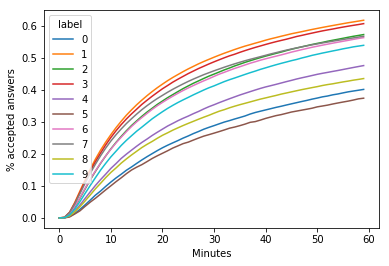

In [135]:
plot_data = pd.concat([df_witht.groupby('label')['TimeToFirstAcceptedAnswer'].apply(
    lambda x: pd.Series(np.mean((x.notna()) & (x <= timedelta(minutes = i))), [i])) for i in range(0, 60)])
plot_data = pd.DataFrame(plot_data).reset_index()
plot_data.columns = ['label', 'Minutes', 'Cumulative_Percentage']
plot_data.pivot(index='Minutes', columns='label', values='Cumulative_Percentage').plot()
plt.ylabel('% accepted answers')
plt.show()